In [3]:
import re
import torch
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from vncorenlp import VnCoreNLP
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, recall_score
import pickle

/home/duy/anaconda3/envs/py39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
labels_task_1 = ["no-spam", "spam"]
labels_task_2 = ["no-spam", "spam-1", "spam-2", "spam-3"]

def show_predict_result(trainer, test_dataset, y_test, labels):
    y_pred_classify = trainer.predict(test_dataset)
    y_pred = np.argmax(y_pred_classify.predictions, axis=-1)
    cf = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cf, index = labels, columns = labels)
    sns.heatmap(df_cm, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})
    print("F1 - micro:", f1_score(y_test, y_pred, average='micro'))
    print("F1 - macro:", f1_score(y_test, y_pred, average='macro'))
    print("Accuracy:", accuracy_score(y_test, y_pred))


class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [5]:
train_data = pd.read_csv("/home/duy/Documents/NTD_Data_Science_Spam/dataset/train.csv")
test_data = pd.read_csv("/home/duy/Documents/NTD_Data_Science_Spam/dataset/test.csv")
dev_data = pd.read_csv('/home/duy/Documents/NTD_Data_Science_Spam/dataset/dev.csv')
STOPWORDS_PATH = ('/home/duy/Documents/NTD_Data_Science_Spam/dataset/vietnamese-stopwords-dash.txt')

In [6]:
#Load dữ liệu
X_train = train_data.iloc[:, 0:2]
y_train = train_data.iloc[:, 2:4]

X_dev = dev_data.iloc[:, 0:2]
y_dev = dev_data.iloc[:, 2:4]

X_test = test_data.iloc[:, 0:2]
y_test = test_data.iloc[:, 2:4]

In [7]:
vncorenlp = VnCoreNLP("vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m')

In [8]:
with open(STOPWORDS_PATH, "r") as ins:
    stopwords = []
    for line in ins:
        dd = line.strip('\n')
        stopwords.append(dd)
    stopwords = set(stopwords)

In [9]:
def filter_stop_words(train_sentences, stop_words):
    new_sent = [word for word in train_sentences.split() if word not in stop_words]
    train_sentences = ' '.join(new_sent)
        
    return train_sentences


def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)


def preprocess(text, tokenized=True, lowercased=True):
    # text = ViTokenizer.tokenize(text)
    # text = ' '.join(vncorenlp.tokenize(text)[0])
    text = filter_stop_words(text, stopwords)
    text = deEmojify(text)
    text = text.lower() if lowercased else text
    if tokenized:
        pre_text = ""
        sentences = vncorenlp.tokenize(text)
        for sentence in sentences:
            pre_text += " ".join(sentence)
        text = pre_text
    return text


def pre_process_features(X, y1, y2, tokenized=True, lowercased=True):
    X = np.array(X)
    y1 = np.array(y1)
    y2 = np.array(y2)
    X = [preprocess(str(p), tokenized=tokenized, lowercased=lowercased) for p in list(X)]
    for idx, ele in enumerate(X):
        if not ele:
            np.delete(X, idx)
            np.delete(y1, idx)
            np.delete(y2, idx)
    return X, y1, y2

In [10]:
train_X, train_y, train_y_spam = pre_process_features(X_train['Comment'], y_train['Label'], y_train['SpamLabel'], tokenized=True, lowercased = False)
dev_X, dev_y, dev_y_spam = pre_process_features(X_dev['Comment'], y_dev['Label'], y_dev['SpamLabel'], tokenized=True, lowercased = False)
test_X, test_y, test_y_spam = pre_process_features(X_test['Comment'], y_test['Label'], y_test['SpamLabel'], tokenized=True, lowercased = False)

In [11]:
model = AutoModelForSequenceClassification.from_pretrained("vinai/phobert-base", num_labels = 2)
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['

In [12]:
import os
    
train_encodings = tokenizer(train_X, truncation=True, padding=True, max_length=100)
dev_encodings = tokenizer(dev_X, truncation=True, padding=True, max_length=100)
test_encodings = tokenizer(test_X, truncation=True, padding=True, max_length=100)

train_dataset = BuildDataset(train_encodings, train_y)
dev_dataset = BuildDataset(dev_encodings, dev_y)
test_dataset = BuildDataset(test_encodings, test_y)

OUTPUT_DIR = os.path.join('/home/duy/Documents/NTD_Data_Science_Spam/dataset', 'phobert', 'task_2')

training_args = TrainingArguments(    
    output_dir= OUTPUT_DIR,       
    num_train_epochs=5,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=16,   
    warmup_steps=500,                
    weight_decay=0.01,
    no_cuda=False,
    do_eval=True
)

trainer = Trainer(
    model=model,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=dev_dataset             
)
trainer.train()
trainer.save_model(OUTPUT_DIR)
with open('model.pkl', 'wb') as f:
    pickle.dump(trainer.model, f)


/home/duy/anaconda3/envs/py39/lib/python3.9/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/duy/transformers/src/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
 11%|█         | 500/4475 [55:42<7:23:09,  6.69s/it] 

{'loss': 0.4072, 'learning_rate': 5e-05, 'epoch': 0.56}


 22%|██▏       | 1000/4475 [1:53:28<6:44:13,  6.98s/it]

{'loss': 0.3044, 'learning_rate': 4.3710691823899376e-05, 'epoch': 1.12}


 34%|███▎      | 1500/4475 [2:43:26<5:12:41,  6.31s/it]

{'loss': 0.2637, 'learning_rate': 3.7421383647798744e-05, 'epoch': 1.68}


 45%|████▍     | 2000/4475 [3:56:13<4:53:49,  7.12s/it]

{'loss': 0.2355, 'learning_rate': 3.113207547169811e-05, 'epoch': 2.23}


 56%|█████▌    | 2500/4475 [5:06:01<5:15:40,  9.59s/it]

{'loss': 0.1985, 'learning_rate': 2.4842767295597485e-05, 'epoch': 2.79}


 67%|██████▋   | 3000/4475 [6:05:24<2:40:55,  6.55s/it]

{'loss': 0.1594, 'learning_rate': 1.8553459119496856e-05, 'epoch': 3.35}


 78%|███████▊  | 3500/4475 [7:01:50<1:47:11,  6.60s/it]

{'loss': 0.1333, 'learning_rate': 1.2264150943396227e-05, 'epoch': 3.91}


 89%|████████▉ | 4000/4475 [7:57:18<51:18,  6.48s/it]  

{'loss': 0.1012, 'learning_rate': 5.974842767295598e-06, 'epoch': 4.47}


100%|██████████| 4475/4475 [8:54:29<00:00,  7.17s/it]


{'train_runtime': 32069.5061, 'train_samples_per_second': 2.23, 'train_steps_per_second': 0.14, 'train_loss': 0.21111490942246422, 'epoch': 5.0}


293it [11:26,  2.34s/it]                         


F1 - micro: 0.8990941117262204
F1 - macro: 0.8708275528611766
Accuracy: 0.8990941117262204


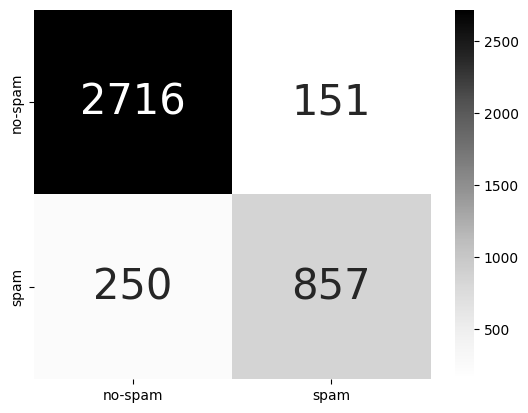

In [14]:
show_predict_result(trainer, test_dataset, test_y, labels_task_1)

 F1 - micro là tổng quan của F1-score cho tất cả các lớp
 F1 - macro là trung bình của F1-score của các lớp riêng lẻ. 
 Accuracy là tỷ lệ dự đoán chính xác trên toàn bộ tập dữ liệu kiểm tra. Kết quả này cho thấy mô hình có hiệu suất tương đối tốt trong việc dự đoán nhãn trên tập dữ liệu kiểm tra.